# Tutorial: Introduction to Modeling in Gen

Welcome! In this tutorial, you'll get your feet wet with Gen, a
multi-paradigm platform for probabilistic modeling and inference. By
"multi-paradigm," we mean that Gen supports many different approaches to
modeling and inference:

- Unsupervised learning and posterior inference in generative models using
  Monte Carlo,  variational, EM, and stochastic gradient techniques.

- Supervised learning of conditional inference models (e.g. supervised
  classification and regression).

- Hybrid approaches including amortized inference / inference compilation,
  variational autoencoders, and semi-supervised learning.

Don't worry if you haven't seen some of these approaches before. One goal of
these tutorials will be to introduce you to a subset of them,
from a unified probabilistic programming perspective.

#### In this Tutorial

Approaching a problem from a probabilistic perspective requires both *modeling*
and *inference*:

- **Modeling**: You first need to frame the problem — and any assumptions you
  bring to the table — as a probabilistic model. A huge variety of problems can
  be viewed from a modeling & inference lens, if you set them up properly. 
  **This notebook is about how to think of problems in this light, and how to use Gen**
  **to formally specify your assumptions and the tasks you wish to solve.**
  
- **Inference**: You then need to do the hard part: inference, that is, 
  solving the problem. In this notebook, we'll use a particularly simple 
  *generic* inference algorithm: importance sampling with the prior as our
  proposal distributions. With enough computation, the algorithm 
  can in theory solve any modeling and inference problem, but in practice, for most problems of
  interest, it is too slow to achieve accurate results in a reasonable amount of time. 
  **Future tutorials introduce some of Gen's**
  **programmable inference features**, 
  which let you tailor the inference algorithm for use with more complex models (Gen will still automate the math!).

Throughout this 
tutorial,
we will emphasize key degrees of modeling flexibility
afforded by the probabilistic programming approach, for example:

- Using a stochastic branching and function abstraction to express
  uncertainty about which of multiple models is appropriate.

- Representing models with an unbounded number of parameters (a 'Bayesian
  non-parametric' model) using loops and recursion.

We'll also introduce a technique for validating a model and
inference algorithm by predicting new data from inferred parameters, and
comparing this data to the observed data set.

However, this
tutorial
does not exhaustively cover all features of Gen's modeling language. 
For example, Gen's modeling combinators and its static modeling language
enable improved performance, but are not covered here.

## Outline

**Section 1.** [Julia, Gen, and this Jupyter notebook](#julia-gen-jupyter)

**Section 2.** [Writing a probabilistic model as a generative function](#writing-model)

**Section 3.** [Doing posterior inference](#doing-inference)

**Section 4.** [Predicting new data](#predicting-data)

**Section 5.** [Calling other generative functions](#calling-functions)

**Section 6.** [Modeling with an unbounded number of parameters](#infinite-space)

## 1. Julia, Gen, and this Jupyter notebook  <a name="julia-gen-jupyter"></a>

Gen is a package for the Julia language. The package can be loaded with:

In [29]:
using Pun

include("../examples.jl");

Gen programs typically consist of a combination of (i) probabilistic models written in modeling languages and (ii) inference programs written in regular Julia code. Gen provides a built-in modeling language that is itself based on Julia.

This tutorial uses a Jupyter notebook. All cells in the notebook are regular Julia cells. In Julia, semicolons are optional at the end of statements; we will use them at the end of some cells so that the value of the cell is not printed.

In [3]:
a = 1 + 1

2

In [4]:
a = 1 + 1;

This notebook uses the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) Julia package for plotting.

In [5]:
using Plots

This notebook will make use of Julia symbols. Note that a Julia symbol is different from a Julia string:

In [6]:
typeof(:foo)

Symbol

In [7]:
typeof("foo")

String

## 2. Writing a probabilistic model as a generative function  <a name="writing-model"></a>

Probabilistic models are represented in Gen as *generative functions*.
Generative functions are used to represent a variety of different types of
probabilistic computations including generative models, inference models,
custom proposal distributions, and variational approximations (see the [Gen
documentation](https://www.gen.dev/docs/stable/ref/gfi/) or the 
[paper](https://dl.acm.org/doi/10.1145/3314221.3314642)). In this
tutorial,
we focus on implementing _generative models_. A generative model represents
a data-generating process; as such, it encodes any assumptions we have about
our data and our problem domain.


The simplest way to construct a generative function is by using the [built-in
modeling DSL](https://www.gen.dev/docs/stable/ref/modeling/). Generative
functions written in the built-in modeling DSL are based on Julia function
definition syntax, but are prefixed with the `@gen` macro:

```julia
@gen function function_name_here(input_arguments)
    # Function body...
end
```

The function represents the data-generating process we are modeling.
Conceptually, every time we run the function, it should generate a new
"synthetic dataset" in line with our assumptions. Along the way, it will make
random choices; each random choice it makes can be thought of as adding
a random variable to a probabilistic model.

Within the function body, most Julia code is permitted, but random choices use
special syntax that annotates them with an _address_:

```julia
{addr} ~ distribution(parameters)
```

A simple example of such an invocation is a normal distribution parametrized
with mean 0 and standard deviation 1:

```julia
my_variable = {:my_variable_address} ~ normal(0, 1)
```

Every random choice must be given an _address_, which can be
an arbitrary value—but we often use a symbol. 
(`:my_variable_address` is a symbol in the Julia language.)
Think of the address as the name of a particular random choice, which
is distinct from the name of the variable. For example, consider
the following code:

```julia
x = {:initial_x} ~ normal(0, 1)
if x < 0
    x = x + ({:addition_to_x} ~ normal(2, 1))
end
```

This code manipulates a single variable, `x`, but may make up to two random
choices: `:initial_x` and `:addition_to_x`.


Note that we can only use `~` to give addresses to _random choices_. 
The following will _not_ work because the code is trying to trace the
expression `sin(x)` which is an invocation of an ordinary Julia function, not
a distribution. 
```Julia
# INVALID:
my_variable = {:not_a_random_choice} ~ sin(x)
```
(We will see a bit later that it is _also_ possible to use `~`
to sample from helper _generative functions_, not just primitive 
distributions like `normal`. But for now, think of `~` as being
for making random choices.)

### Example: Bayesian linear regression

Suppose we have a dataset of points $(x, y)$ in the plane, and we'd like 
to infer a likely slope and intercept that explains their (linear) relationship.
To approach this problem from a probabilistic perspective, we first need to
develop a model. The model answers the question: how might this dataset have
come to be? It also encodes our assumptions, e.g., our assumption that our
data is explained by a linear relationship between $x$ and $y$.

The generative function below represents a probabilistic model of a linear
relationship in the x-y plane. Given a set of $x$ coordinates, it randomly
chooses a line in the plane and generates corresponding $y$ coordinates so
that each $(x, y)$ is near the line. We might think of this function as
modeling house prices as a function of square footage, or the measured volume
of a gas as a function of its measured temperature.

In [256]:
struct LinearModel
    slope
    intercept
end

# We define a function to compute y for a given x
function evaluate_model(model::LinearModel, x::Real)
    return model.slope * x + model.intercept
end

linear_model_prior = @prob begin
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope <<= normal(0, 1)
    intercept <<= normal(0, 2)
    return LinearModel(slope, intercept)
end

line_model(xs; prior=linear_model_prior) = @prob begin
    linear_model <<= prior

    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    ys <<= mapM(x -> normal(evaluate_model(linear_model, x), 0.1), xs)

    return linear_model, ys
end;

The generative function takes as an argument a vector of x-coordinates. We create one below:

In [156]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

In [157]:
(model, ys), logprob, basis  = simulate(line_model(xs));

In order to understand the probabilistic behavior of a generative function, it is helpful to be able to visualize its traces. Below, we define a function that uses PyPlot to render a trace of the generative function above. The rendering shows the x-y data points and the line that is represented by the slope and intercept choices.

In [158]:
function render_trace((model, xs, ys); show_data=true)

    xmin = minimum(xs)
    xmax = maximum(xs)

    # Draw the line
    y = x -> evaluate_model(model, x)
    test_xs = collect(range(-5, stop=5, length=1000))
    fig = plot(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
        xlim=(xmin, xmax), ylim=(xmin, xmax))

    if show_data
        # Plot the data set
        scatter!(xs, ys, c="black", label=nothing)
    end

    return fig
end;

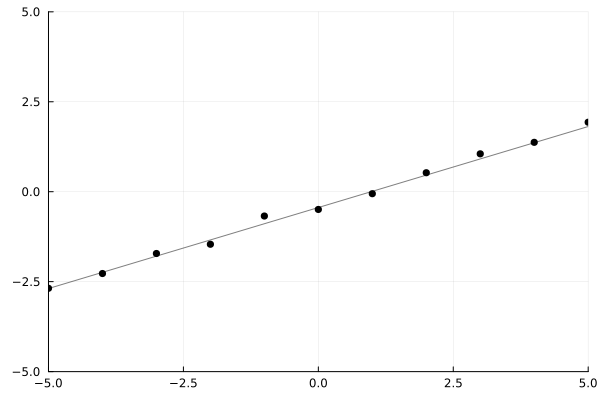

In [159]:
render_trace((model, xs, ys))

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavior. The cell below renders a grid of traces.

In [95]:
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

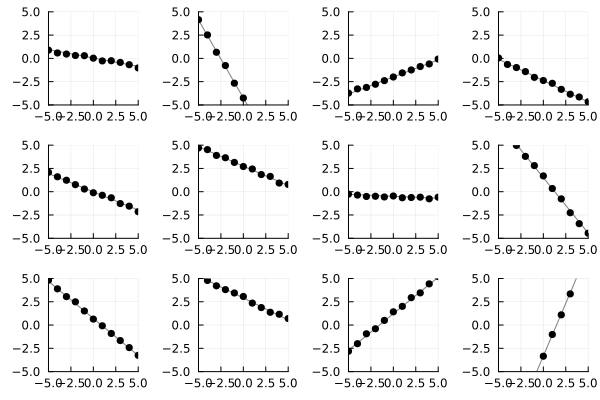

In [96]:
traces = []
for _ in 1:12
    (model, ys), _, _ = simulate(line_model(xs))
    push!(traces, (model, xs, ys))
end
grid(render_trace, traces)

-------------------------------
### Exercise

Write a model that generates a sine wave with random phase, period and
amplitude, and then generates y-coordinates from a given vector of
x-coordinates by adding noise to the value of the wave at each x-coordinate.
Use a  `gamma(1, 1)` prior distribution for the period, and a `gamma(1, 1)`
prior distribution on the amplitude (see
[`Gen.gamma`](https://www.gen.dev/docs/stable/ref/distributions/#Gen.gamma)).
Sampling from a Gamma distribution will ensure to give us postive real values.
Use a uniform distribution between 0 and $2\pi$ for the phase (see
[`Gen.uniform`](https://www.gen.dev/docs/stable/ref/distributions/#Gen.uniform)).

The sine wave should implement:

$ y(x) = a \sin(2\pi \frac{1}{p} x + \varphi)$,

where $a$ is the amplitude, $p$ is the period and $\varphi$ is the phase.  In
Julia the constant $\pi$ can be expressed as either `pi` or `π` (unicode).

When calling `trace = Gen.simulate(sine_model, (xs,))`, the following choices should appear:
- amplitude: `trace[:amplitude]`
- period: `trace[:period]`
- phase: `trace[:phase]`

We have provided some starter code for the sine wave model:

In [250]:
struct SineModel
    period
    amplitude
    phase
end

function evaluate_model(model::SineModel, x::Real)
    return model.amplitude * sin(2 * pi * x / model.period + model.phase)
end

sine_model_prior = @prob begin
    period <<= gamma(1, 1)
    amplitude <<= gamma(1, 1)
    phase <<= uniform(0, 2 * pi)
    return SineModel(period, amplitude, phase)
end

sine_model(xs::Vector{Float64}; prior=sine_model_prior) = @prob begin
    periodic_model <<= prior
    ys <<= mapM(x -> normal(evaluate_model(periodic_model, x), 0.1), xs)
    return periodic_model, ys
end;

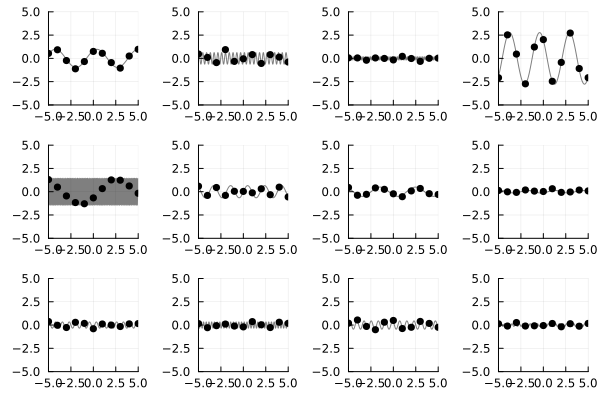

In [161]:
traces = []
for _ in 1:12
    (model, ys), _, _ = simulate(sine_model(xs))
    push!(traces, (model, xs, ys))
end
grid(render_trace, traces)

<hr>
<!-- # Solution:
@gen function sine_model(xs)
    period = {:period} ~ gamma(1, 1)
    amplitude = {:amplitude} ~ gamma(1, 1)
    phase = {:phase} ~ uniform(0, 2*pi)

    # Define a deterministic sine wave with the values above
    function y(x)
        return amplitude * sin(x * (2 * pi / period) + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end

    return y
end; -->

## 3. Doing Posterior inference  <a name="doing-inference"></a>

Of course, we don't really care about generating lots of pictures of lines
(or sine waves). We'd really like to begin with an actual dataset of observed
$(x, y)$ points, and infer the corresponding slope and intercept (or phase,
period, and amplitude). This task is called _posterior inference_.

We now will provide a data set of y-coordinates and try to draw inferences
about the process that generated the data. We begin with the following data
set:

In [309]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

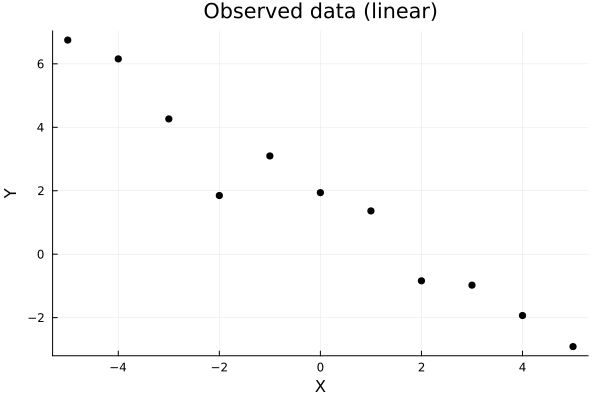

In [310]:
scatter(xs, ys, color="black", label=nothing, title="Observed data (linear)", xlabel="X", ylabel="Y")

We will assume that the line model was responsible for generating the data,
and infer values of the slope and intercept that explain the data.

To do this, we write a simple *inference program* that takes the model we are
assuming generated our data, the data set, and the amount of computation to
perform, and returns a trace of the function that is approximately sampled
from the _posterior distribution_ on traces of the function, given the
observed data. That is, the inference program will try to find a trace that
well explains the dataset we created above. We can inspect that trace to find
estimates of the slope and intercept of a line that fits the data.

Functions like `importance_resampling` expect us to provide a _model_ and
also an _choice map_ representing our data set and relating it to the model.
A choice map maps random choice addresses from the model to values from our
data set. Here, we want to tie model addresses like `(:y, 4)` to data set
values like `ys[4]`:

In [286]:
using LogExpFunctions

In [287]:
function do_inference(model, proposal, xs, ys, amount_of_computation)
    # For now we just grab the basis from a simulate call
    _, _, basis = simulate(model(xs))

    # Call importance_sampling to obtain weighted particles 
    # Each is a possible execution, with weight corresponding to the posterior 
    weighted_particles = Pun.importance_sampling(model(xs), proposal, ys, basis, amount_of_computation)

    # Then resample according to the weights
    # We use logsumexp trick for numerical stability
    particles, log_weights = getindex.(weighted_particles, 1), getindex.(weighted_particles, 2)
    weights = exp.(log_weights .- logsumexp(log_weights))
    resampler = @prob begin
        index <<= categorical(weights)
        return index
    end
    index, _, _ = simulate(resampler)
    return particles[index]
end;

We can run the inference program to obtain a trace, and then visualize the result:

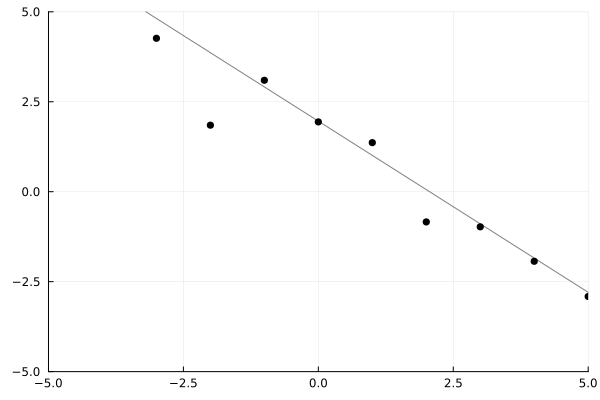

In [288]:
proposal_function = y -> linear_model_prior

linear_model = do_inference(line_model, proposal_function, xs, ys, 100)
render_trace((linear_model, xs, ys))

We see that `importance_resampling` found a reasonable slope and intercept to explain the data. We can also visualize many samples in a grid:

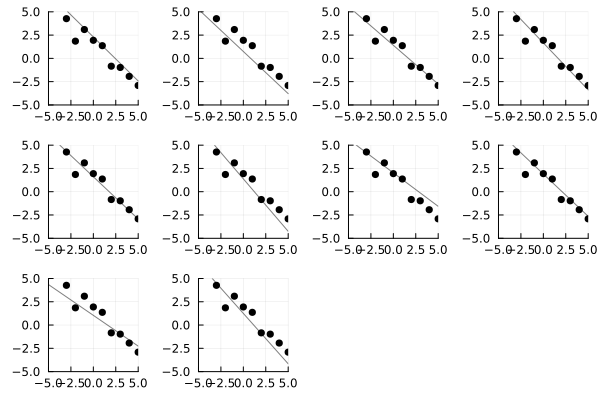

In [289]:
traces = [(do_inference(line_model, proposal_function, xs, ys, 100), xs, ys) for _=1:10];
grid(render_trace, traces)

We can see here that there is some uncertainty: with our limited data, we can't be 100% sure exactly where the line is. We can get a better sense for the variability in the posterior distribution by visualizing all the traces in one plot, rather than in a grid. Each trace is going to have the same observed data points, so we only plot those once, based on the values in the first trace:

In [290]:
function overlay(renderer, traces; same_data=true, args...)
    fig = renderer(traces[1], show_data=true, args...)
    
    _, xs, _ = traces[1]
    xmin = minimum(xs)
    xmax = maximum(xs)

    for i=2:length(traces)
        model, _, _ = traces[i]
        y = x -> evaluate_model(model, x)
        test_xs = collect(range(-5, stop=5, length=1000))
        fig = plot!(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                    xlim=(xmin, xmax), ylim=(xmin, xmax))
    end
    return fig
end;

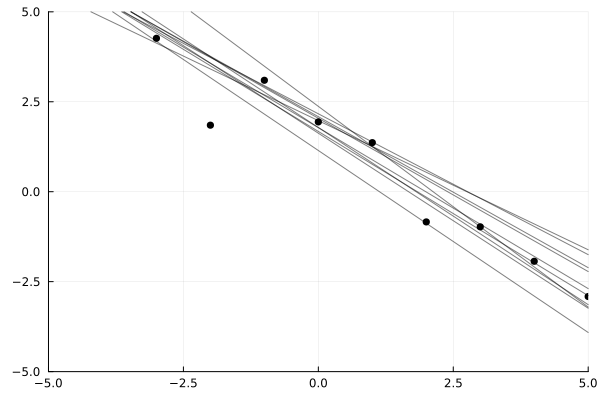

In [292]:
traces = [(do_inference(line_model, proposal_function, xs, ys, 100), xs, ys) for _=1:10];
overlay(render_trace, traces)

--------------

### Exercise

The results above were obtained for `amount_of_computation = 100`. Run the algorithm with this value set to `1`, `10`, and `1000`, etc.  Which value seems like a good tradeoff between accuracy and running time? Discuss.

------------------

### Exercise
Consider the following data set.

In [293]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

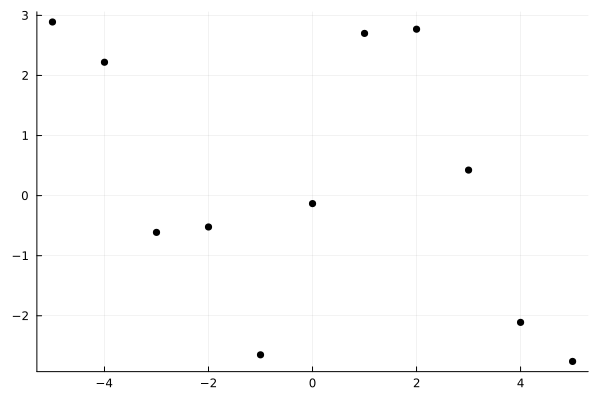

In [294]:
scatter(xs, ys_sine, color="black", label=nothing)

Write an inference program that generates traces of `sine_model` that explain this data set. Visualize the resulting distribution of traces. Temporarily change the prior distribution on the period to be `gamma(1, 1)`  (by changing and re-running the cell that defines `sine_model` from a previous exercise). Can you explain the difference in inference results when using `gamma(1, 1)` vs `gamma(5, 1)` prior on the period? How much computation did you need to get good results?

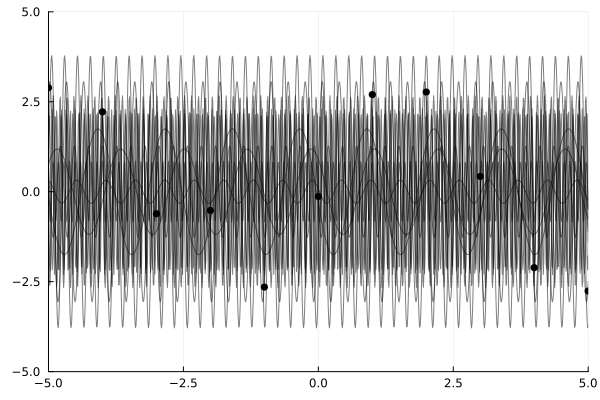

In [296]:
# Using `gamma(1, 1)` (default prior)
sine_model_prior = @prob begin
    period <<= gamma(1, 1)
    amplitude <<= gamma(1, 1)
    phase <<= uniform(0, 2 * pi)
    return SineModel(period, amplitude, phase)
end

traces = [(do_inference(sine_model, y -> sine_model_prior, xs, ys_sine, 100), xs, ys_sine) for _ = 1:10];
overlay(render_trace, traces)

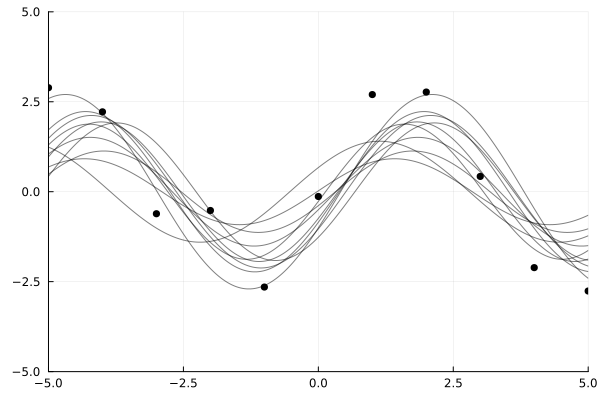

In [300]:
# Using `gamma(5, 1)` prior

sine_model_prior = @prob begin
    period <<= gamma(5, 1)
    amplitude <<= gamma(1, 1)
    phase <<= uniform(0, 2 * pi)
    return SineModel(period, amplitude, phase)
end

# Need to accept xs as an arg
model = xs -> sine_model(xs, prior=sine_model_prior)

traces = [(do_inference(model, y -> sine_model_prior, xs, ys_sine, 100), xs, ys_sine) for _ = 1:10];
overlay(render_trace, traces)

## 4. Predicting new data  <a name="predicting-data"></a>

What if we'd want to predict `ys` given `xs`?

Using the API method
[`generate`](https://www.gen.dev/docs/dev/ref/gfi/#Gen.generate), we
can generate a trace of a generative function in which the values of certain
random choices are constrained to given values. The constraints are a choice
map that maps the addresses of the constrained random choices to their
desired values.

For example:


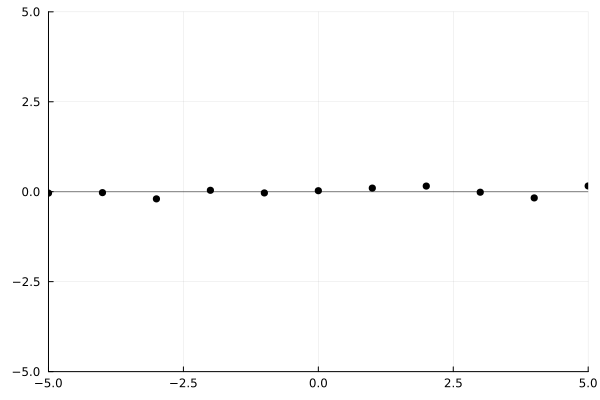

In [308]:
fixed_prior(slope, intercept) = @prob begin
    model <<= dirac(LinearModel(slope, intercept))
    return model
end

(model, ys_fixed), _, _ = simulate(line_model(xs, prior=fixed_prior(0., 0.)))
render_trace((model, xs, ys_fixed))

Note that the random choices corresponding to the y-coordinates are still made randomly. Run the cell above a few times to verify this.


We will use the ability to run constrained executions of a generative
function to predict the value of the y-coordinates at new x-coordinates by
running new executions of the model generative function in which the random
choices corresponding to the parameters have been constrained to their
inferred values.  We have provided a function below (`predict_new_data`) that
takes a trace, and a vector of new x-coordinates, and returns a vector of
predicted y-coordinates corresponding to the x-coordinates in `new_xs`. We
have designed this function to work with multiple models, so the set of
parameter addresses is an argument (`param_addrs`):


In [302]:
function predict_new_data(model, inferred_model, new_xs::Vector{Float64})
    
    # Generate a new 'fixed prior' from the inferred model
    constrained_prior = @prob begin
        model <<= dirac(inferred_model)
        return model
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values.
    (model, ys), _, _ = simulate(model(new_xs, prior=constrained_prior))
    
    return ys
end;

To illustrate, we call the function above given the previous trace (which
constrained slope and intercept to be zero).

In [303]:
predict_new_data(line_model, model, [1., 2., 3.])

3-element Vector{Any}:
 -0.15568106875194643
  0.05231629074204748
  0.0779094336163162

The cell below defines a function that first performs inference on an
observed data set `(xs, ys)`, and then runs `predict_new_data` to generate
predicted y-coordinates. It repeats this process `num_traces` times, and
returns a vector of the resulting y-coordinate vectors.

In [304]:
function infer_and_predict(model, proposal, xs, ys, new_xs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        inferred_model = do_inference(model, proposal, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, inferred_model, new_xs))
    end
    pred_ys
end;

To illustrate, we generate predictions at `[1., 2., 3.]` given one (approximate) posterior
trace.

In [305]:
pred_ys = infer_and_predict(line_model, y -> linear_model_prior, xs, ys, [1., 2., 3.], 1, 1000)

1-element Vector{Any}:
 Any[0.08216398761676466, 0.0851612781611315, 0.03302441823973602]

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [306]:
function plot_predictions(xs, ys, new_xs, pred_ys; title="predictions")
    fig = scatter(xs, ys, color="red", label="observed data", title=title)
    for (i, pred_ys_single) in enumerate(pred_ys)
        scatter!(new_xs, pred_ys_single, color="black", alpha=0.1, label=i == 1 ? "predictions" : nothing)
    end
    return fig
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

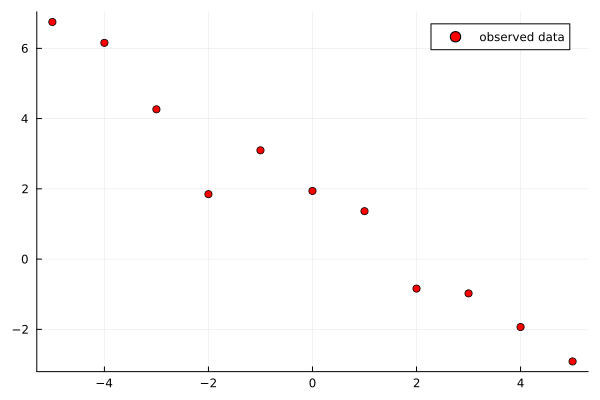

In [311]:
scatter(xs, ys, color="red", label="observed data")

We will use the inferred values of the parameters to predict y-coordinates for x-coordinates in the interval 5 to 10 from which data was not observed. We will also predict new data within the interval -5 to 5, and we will compare this data to the original observed data. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*. This tutorial does not intend to give a rigorous overview behind techniques for checking the quality of a model, but intends to give high-level intuition.

In [312]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data:

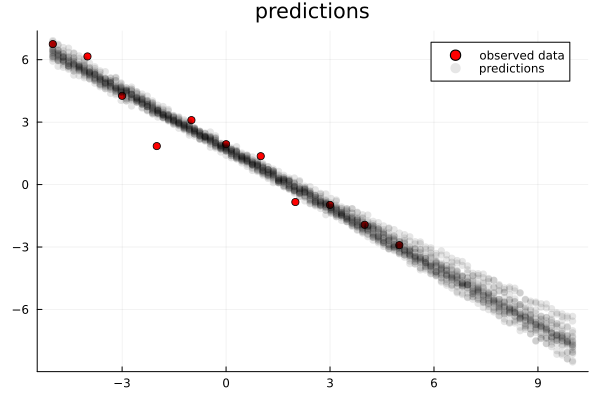

In [318]:
pred_ys = infer_and_predict(line_model, y -> linear_model_prior, xs, ys, new_xs, 20, 1000)
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with the following data set, which has significantly more noise.

In [319]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

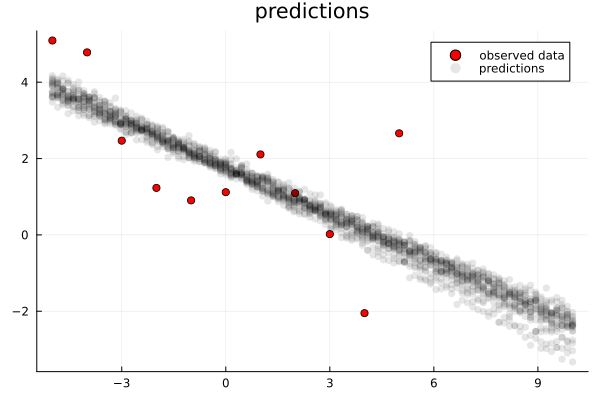

In [320]:
pred_ys = infer_and_predict(line_model, y -> linear_model_prior, xs, ys_noisy, new_xs, 20, 1000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

We first write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [323]:
line_model_fancy(xs; prior=linear_model_prior) = @prob begin
    linear_model <<= prior
    noise <<= gamma(1, 1)

    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    ys <<= mapM(x -> normal(evaluate_model(linear_model, x), noise), xs)
    
    return linear_model, noise, ys
end;

Then, we compare the predictions using inference of the unmodified and modified models on the `ys` data set:

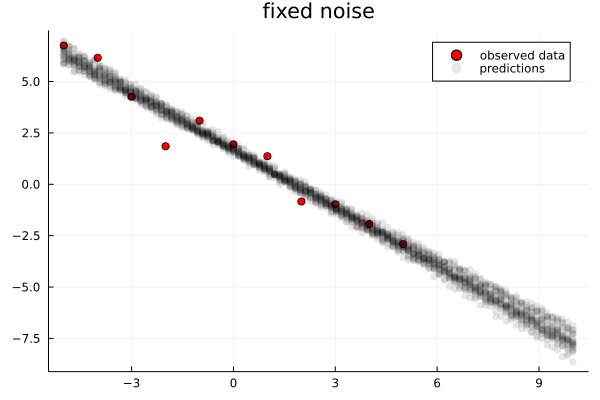

In [328]:
pred_ys = infer_and_predict(line_model, y -> linear_model_prior, xs, ys, new_xs, 20, 1000)
fixed_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="fixed noise")

# pred_ys = infer_and_predict(line_model_fancy, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
# inferred_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="inferred noise")

# plot(fixed_noise_plot, inferred_noise_plot)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference of the unmodified and modified models on the `ys_noisy` data set:

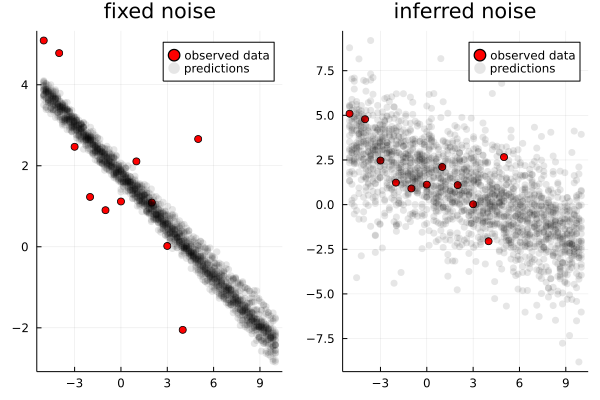

In [59]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
fixed_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="fixed noise")


pred_ys = infer_and_predict(line_model_fancy, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
inferred_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="inferred noise")

plot(fixed_noise_plot, inferred_noise_plot)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend.

-------------------------
### Exercise

Write a modified version of the sine model that makes noise into a random choice. Compare the predicted data with the observed data using `infer_and_predict` and `plot_predictions` for the unmodified and modified models, and for the `ys_sine` and `ys_noisy` data sets. Discuss the results. Experiment with the amount of inference computation used. The amount of inference computation will need to be higher for the model with the noise as a random choice.

We have provided you with starter code:

In [90]:
@gen function sine_model_fancy(xs::Vector{Float64})

    # < your code here >
    
    function y(x)
        # <your code here>
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end
    return y
end;

In [ ]:
# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model, xs, ys_sine, new_xs, [], 20, 1)
fixed_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Fixed noise level")

# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model_fancy, xs, ys_sine, new_xs, [], 20, 1)
inferred_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Inferred noise level")

Plots.plot(fixed_noise_plot, inferred_noise_plot)

In [ ]:
# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model, xs, ys_noisy, new_xs, [], 20, 1)
fixed_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="Fixed noise level")

# Modify the line below to experiment with the amount_of_computation parameter
pred_ys = infer_and_predict(sine_model_fancy, xs, ys_noisy, new_xs, [], 20, 1)
inferred_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="Inferred noise level")

Plots.plot(fixed_noise_plot, inferred_noise_plot)

----
<!-- # Solution
@gen function sine_model_fancy(xs::Vector{Float64})
    period = ({:period} ~ gamma(5, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))
    phase = ({:phase} ~ uniform(0, 2*pi))
    noise = ({:noise} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(x * (2 * pi / period) + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), noise)
    end

    return y
end; -->

## 5. Calling other generative functions  <a name="calling-functions"></a>

In addition to making random choices, generative functions can invoke other
generative functions. To illustrate this, we will write a probabilistic model
that combines the line model and the sine model. This model is able to
explain data using either model, and which model is chosen will depend on the
data. This is called *model selection*.

A generative function can invoke another generative function in three ways:

- **(NOT RECOMMENDED)** using regular Julia function call syntax: `f(x)`

- using the `~` snytax with an address for the call: `{addr} ~ f(x)`

- using the `~` syntax with a wildcard address: `{*} ~ f(x)`

When invoking using regular function call syntax, the random choices made by
the callee function are not traced at all, and Gen cannot reason about them during inference. 
When invoking using `~` with a _wildcard_ address (`{*} ~ f(x)`), the random choices of the 
callee function are imported directly into the caller's trace. So, for example, if `f` makes a choice
called `:f_choice`, then the caller's trace will have a choice called `:f_choice` too. 
Note that a downside of this is that if `f` is called _twice_ by the same caller, then the two 
choices called `:f_choice` will clash, leading to an error.
In this case, it is best to provide an address (`{addr} ~ f(x)`): `f`'s random choices will
be placed under the _namespace_ `addr`. 

In [61]:
@gen function foo()
    {:y} ~ normal(0, 1)
end

@gen function bar()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with a wildcard address.
    # Its choices (:y) will appear directly
    # within the trace of `bar`.
    {*} ~ foo()
end

@gen function bar_using_namespace()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with the address `:z`.
    # The internal choice `:y` of `foo`
    # will appear in our trace at the
    # hierarchical address `:z => :y`.
    {:z} ~ foo()
end;

We first show the addresses sampled by `bar`:

In [62]:
trace = Gen.simulate(bar, ())
Gen.get_choices(trace)

│
├── :y : 0.6475752978557953
│
└── :x : true


And the addresses sampled by `bar_using_namespace`:

In [63]:
trace = Gen.simulate(bar_using_namespace, ())
Gen.get_choices(trace)

│
├── :x : true
│
└── :z
    │
    └── :y : 0.3801328264226968


Using `{addr} ~ f()`, with a namespace, can help avoid address collisions for complex models.

A hierarchical address is represented as a Julia `Pair`, where the first element of the pair is the first element of the address and the second element of the pair is the rest of the address:

In [64]:
trace[Pair(:z, :y)]

0.3801328264226968

Julia uses the `=>` operator as a shorthand for the `Pair` constructor, so we can access choices at hierarchical addresses like:

In [65]:
trace[:z => :y]

0.3801328264226968

If we have a hierarchical address with more than two elements, we can construct the address by chaining the `=>` operator:

In [66]:
@gen function baz()
    {:a} ~ bar_using_namespace()
end

trace = simulate(baz, ())

trace[:a => :z => :y]

0.5622991768999647

Note that the `=>` operator associated right, so this is equivalent to:

In [67]:
trace[Pair(:a, Pair(:z, :y))]

0.5622991768999647

Now, we write a generative function that combines the line and sine models. It makes a Bernoulli random choice (e.g. a coin flip that returns true or false) that determines which of the two models will generate the data.

In [68]:
@gen function combined_model(xs::Vector{Float64})
    if ({:is_line} ~ bernoulli(0.5))
        # Call line_model_fancy on xs, and import
        # its random choices directly into our trace.
        return ({*} ~ line_model_fancy(xs))
    else
        # Call sine_model_fancy on xs, and import
        # its random choices directly into our trace
        return ({*} ~ sine_model_fancy(xs))
    end
end;

We visualize some traces, and see that sometimes it samples linear data and other times sinusoidal data.

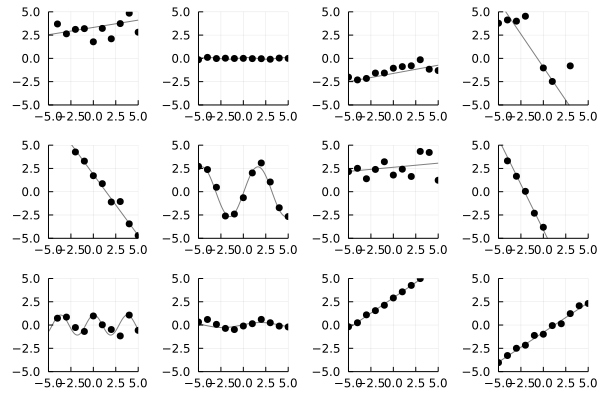

In [69]:
traces = [Gen.simulate(combined_model, (xs,)) for _=1:12];
grid(render_trace, traces)

We run inference using this combined model on the `ys` data set and the `ys_sine` data set. 

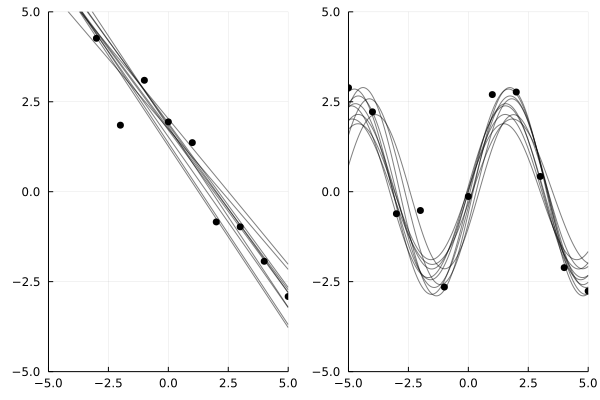

In [71]:
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
linear_dataset_plot = overlay(render_trace, traces)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
sine_dataset_plot = overlay(render_trace, traces)
Plots.plot(linear_dataset_plot, sine_dataset_plot)

The results should show that the line model was inferred for the `ys` data set, and the sine wave model was inferred for the `ys_sine` data set.

-------

### Exercise

Construct a data set for which it is ambiguous whether the line or sine wave model is best. Visualize the inferred traces using `render_combined` to illustrate the ambiguity. Write a program that takes the data set and returns an estimate of the posterior probability that the data was generated by the sine wave model, and run it on your data set.

Hint: To estimate the posterior probability that the data was generated by the sine wave model, run the inference program many times to compute a large number of traces, and then compute the fraction of those traces in which `:is_line` is false.

<hr>

## 6. Modeling with an unbounded number of parameters  <a name="infinite-space"></a>

Gen's built-in modeling language can be used to express models that use an
unbounded number of parameters. This section walks you through development of
a model of data that does not a-priori specify an upper bound on the
complexity of the model, but instead infers the complexity of the model as
well as the parameters. This is a simple example of a *Bayesian
nonparametric* model.

We will consider two data sets:

In [72]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

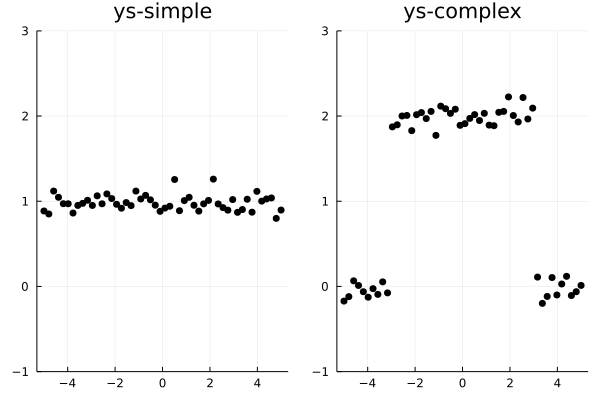

In [73]:
simple_plot = scatter(xs_dense, ys_simple, color="black", label=nothing, title="ys-simple", ylim=(-1, 3))
complex_plot = scatter(xs_dense, ys_complex, color="black", label=nothing, title="ys-complex", ylim=(-1, 3))
Plots.plot(simple_plot, complex_plot)

The data set on the left appears to be best explained as a contant function
with some noise. The data set on the right appears to include two
changepoints, with a constant function in between the changepoints. We want a
model that does not a-priori choose the number of changepoints in the data.
To do this, we will recursively partition the interval into regions. We
define a Julia data structure that represents a binary tree of intervals;
each leaf node represents a region in which the function is constant.

In [74]:
struct Interval
    l::Float64
    u::Float64
end

In [75]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

We now write a generative function that randomly creates such a tree. Note the use of recursion in this function to create arbitrarily large trees representing arbitrarily many changepoints. Also note that we assign the address namespaces `:left` and `:right` to the calls made for the two recursive calls to `generate_segments`.

In [76]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if ({:isleaf} ~ bernoulli(0.7))
        value = ({:value} ~ normal(0, 1))
        return LeafNode(value, interval)
    else
        frac = ({:frac} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        # Call generate_segments recursively!
        # Because we will call it twice -- one for the left 
        # child and one for the right child -- we use
        # addresses to distinguish the calls.
        left = ({:left} ~ generate_segments(l, mid))
        right = ({:right} ~ generate_segments(mid, u))
        return InternalNode(left, right, interval)
    end
end;

We also define some helper functions to visualize traces of the `generate_segments` function.

In [77]:
function render_node!(node::LeafNode)
    plot!([node.interval.l, node.interval.u], [node.value, node.value], label=nothing, linewidth=5)
end

function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;

In [78]:
function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-3, 3))
    render_node!(node)
    return fig
end;

We generate 12 traces from this function and visualize them below. We plot the piecewise constant function that was sampled by each run of the generative function. Different constant segments are shown in different colors. Run the cell a few times to get a better sense of the distribution on functions that is represented by the generative function.

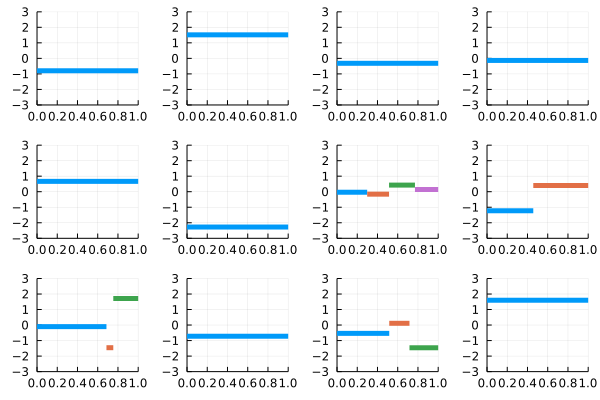

In [81]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
grid(render_segments_trace, traces)

Because we only sub-divide an interval with 30% probability, most of these sampled traces have only one segment.

Now that we have a generative function that generates a random piecewise-constant function, we write a model that adds noise to the resulting constant functions to generate a data set of y-coordinates. The noise level will be a random choice.

In [82]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Our full model
@gen function changepoint_model(xs::Vector{Float64})
    node = ({:tree} ~ generate_segments(minimum(xs), maximum(xs)))
    noise = ({:noise} ~ gamma(0.5, 0.5))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(get_value_at(x, node), noise)
    end
    return node
end;

We write a visualization for `changepoint_model` below:

In [83]:
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace; xlim=(minimum(xs), maximum(xs)))
    render_node!(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.3, markersize=3)
    end
end;

Finally, we generate some simulated data sets and visualize them on top of the underlying piecewise constant function from which they were generated:

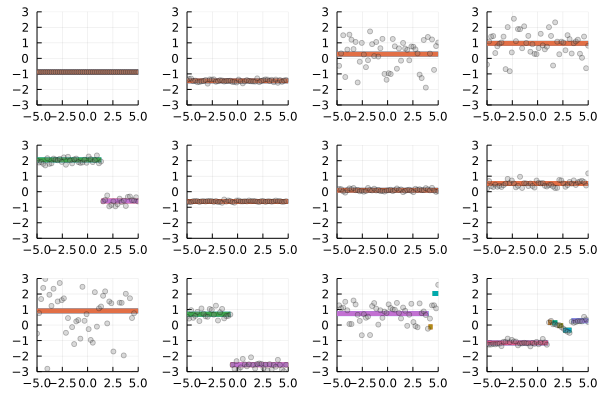

In [85]:
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
grid(render_changepoint_model_trace, traces)

Notice that the amount of variability around the piecewise constant mean function differs from trace to trace.

Now we perform inference for the simple data set:

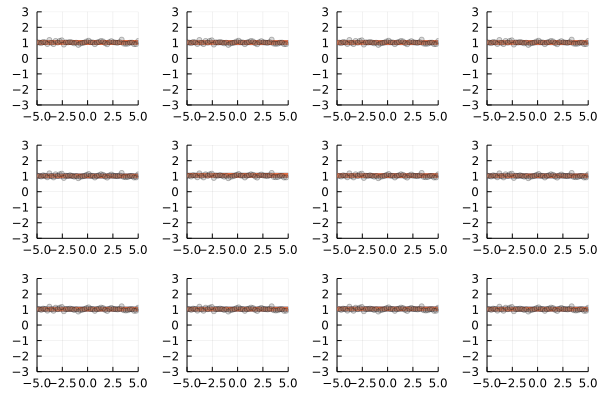

In [196]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

We see that we inferred that the mean function that explains the data is a constant with very high probability.

For inference about the complex data set, we use more computation. You can experiment with different amounts of computation to see how the quality of the inferences degrade with less computation. Note that we are using a very simple generic inference algorithm in this tutorial, which really isn't suited for this more complex task. In later tutorials, we will learn how to write more efficient algorithms, so that accurate results can be obtained with significantly less computation. We will also see ways of annotating the model for better performance, no matter the inference algorithm.

##### Caveat: the following cell may run for 2-3 minutes.

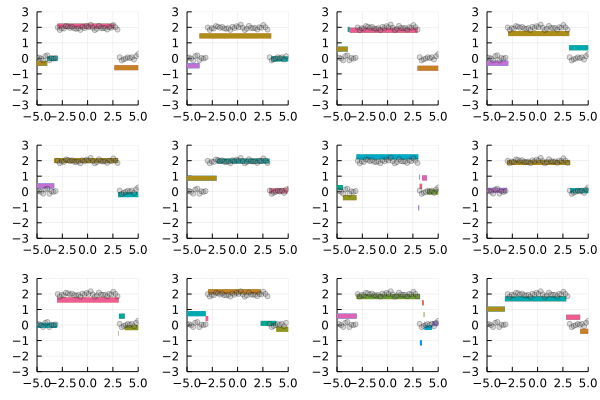

In [197]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, 100000) for _=1:12];
grid(render_changepoint_model_trace, traces)

The results show that more segments are inferred for the more complex data set.

------
### Exercise
Write a function that takes a data set of x- and y-coordinates and plots the histogram of the probability distribution on the number of changepoints.
Show the results for the `ys_simple` and `ys_complex` data sets.

Hint: The return value of `changepoint_model` is the tree of `Node` values. Walk this tree.

-------

### Exercise
Write a new version of `changepoint_model` that uses `{*} ~ ...` without an address to make the recursive calls.

Hint: You will need to guarantee that all addresses are unique. How can you label each node in a binary tree using an integer?

<hr>